In [1]:
# pip install progressbar
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import progressbar
import cv2
import utils as uti
import gradient_functions as gf
from sklearn.cluster import KMeans

# fix random seed
np.random.seed(0)
np.set_printoptions(suppress=True)

---
## Original Image

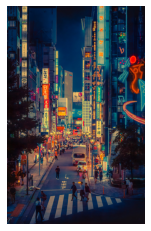

In [3]:
file_name = 'tokyo.png'
I = cv2.imread('images/{}'.format(file_name))
I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
uti.display_image(I)

---
# Preprocessing

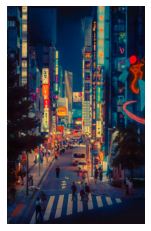

In [4]:
# applying a low pass filter to reduce aliasing that may result from subsampling
# in this case we use a median blur
I_lp = cv2.medianBlur(I, 5)
uti.display_image(I_lp)

Original dimensions:  (1012, 640, 3)
Resized dimensions:  (1012, 640, 3)


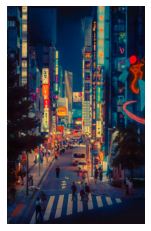

In [5]:
# subsampling image to reduce computation time
# from trial-and-error, subsampling reduced quality of the 
# end result, left scale_percent at 100 to skip this step
print('Original dimensions: ', I.shape)

scale_percent = 100
w = int(I.shape[1] * scale_percent / 100)
h = int(I.shape[0] * scale_percent / 100)
dim = (w, h)

resized = cv2.resize(I_lp, dim)
print('Resized dimensions: ', resized.shape)
uti.display_image(resized)

---
## Color Selection

In [6]:
# we use K-means clustering to obtain our 8 primary colors
kmeans = KMeans(n_clusters=8)
kmeans.fit(resized.reshape(-1, 3))
palette = (kmeans.cluster_centers_).astype(int)

Primary Colors From K-means


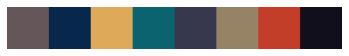

Boosted Color Pallete


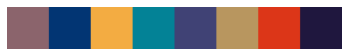

Color Complements


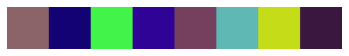

Final Color Palette


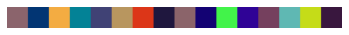

In [7]:
print('Primary Colors From K-means')
uti.display_image(uti.display_colors(palette, len(palette)))

# convert pallete rgb to hsv
palette_hsv = np.apply_along_axis(uti.rgb2hsv, 1, palette)

# apply boosting to colors by adjusting brightness and saturation
palette_hsv = np.apply_along_axis(uti.boost_colors, 1, palette_hsv)

# convert hsv palette to rgb
palette_boosted = np.apply_along_axis(uti.hsv2rgb, 1, palette_hsv)

print('Boosted Color Pallete')
uti.display_image(uti.display_colors(palette_boosted, len(palette_boosted)))

print('Color Complements')
palette_complement = np.apply_along_axis(uti.color_complement, 1, palette_hsv)
palette_complement = np.apply_along_axis(uti.hsv2rgb, 1, palette_complement)
uti.display_image(uti.display_colors(palette_complement, len(palette_complement)))

print('Final Color Palette')
palette_final = np.concatenate((palette_boosted, palette_complement), axis=0)
uti.display_image(uti.display_colors(palette_final, len(palette_final)))

---
## Image Generation

In [8]:
# compute the image gradient
grayscale = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
dx, dy = gf.compute_gradient(grayscale)

In [9]:
# res = cv2.medianBlur(I, 11)
grid = uti.random_grid(resized.shape[0], resized.shape[1], scale=3)
canvas = np.zeros((resized.shape[0], resized.shape[1], 3), np.uint8)
batch_size = 10000

In [10]:
bar = progressbar.ProgressBar()
stroke_scale = int(math.ceil(max(I.shape) / 1000))
cluster_size = 3  # how many dots too appear in each cluster, min 3
d = 1  # how far apart dots will be from each other

for h in bar(range(0, len(grid), batch_size)):
    pixels = np.array([resized[x[0], x[1]] for x in grid[h:min(h + batch_size, len(grid))]])
    color_probs = uti.compute_color_probs(pixels, palette_boosted)
    
    for i, (y, x) in enumerate(grid[h:min(h + batch_size, len(grid))]):
        color_1 = uti.select_color(color_probs[i], palette_final)
        
        direction = gf.direction(dx, dy, y, x) + 90
        angle = math.degrees(direction) + 90
        
        # magnitude = gf.magnitude(dx, dy, y, x)
        # length = int(stroke_scale * math.sqrt(magnitude))
        
        cv2.ellipse(canvas, (x, y), (1, stroke_scale), angle, 0, 360, color_1, -1, cv2.LINE_AA)
        
        # add random noise to image for contrast
        if (random.random() < 0.1):
            rand_color = uti.random_color(palette_final)
            cv2.ellipse(canvas, (x, y), (1, stroke_scale), angle, 0, 360, rand_color, -1, cv2.LINE_AA)
        

100% |########################################################################|


In [12]:
cv2.imwrite('edits/{}.jpeg'.format(file_name), cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))

True

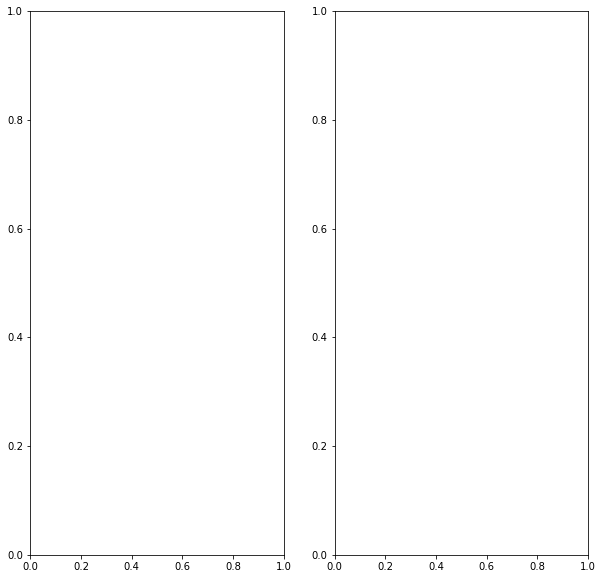

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.imshow(res)